<a href="https://colab.research.google.com/github/RupaliGarg0906/Learn_AI_ML/blob/master/ComputerVision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import all required libraries
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from cv2 import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [3]:
#Mount drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# load dataset filw which is located in mounted drive
dataset= np.load("/content/drive/My Drive/Colab Notebooks/Colab datasets/images.npy",allow_pickle=True)

In [5]:
#Declare all required variables
IMAGE_SIZE=512

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527}, {'x': 0.7692307692307693, 'y': 0.36182902584493043}], 'imageWidth': 1280, 'imageHeight': 697}]


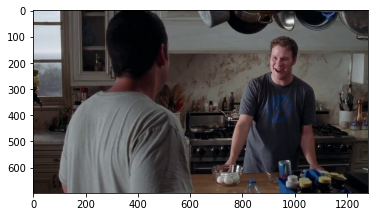

In [6]:
#Show any random image and its corresponding labels to analyse the dataset structurw
plt.imshow(dataset[1][0])
print(dataset[1][1])



We can see dataset is list if 2 list. One list contains images and another contains lists of dictionary which stores coordinates of face 


In [7]:
#Remove images which are of different channels
m=[]
for i in range(dataset.shape[0]):
  if(len(dataset[i][0].shape)<3) or ((dataset[i][0].shape[2])>3):
   m.append(i)
print (m)

[1, 3, 41, 49, 64, 140, 151, 247, 263, 272, 337, 347]


In [8]:
#Declare function that will create dataset and its label
def create_X_label(data):
  mask=np.zeros((data.shape[0],IMAGE_SIZE,IMAGE_SIZE))
  #X=np.zeros((data.shape[0],IMAGE_SIZE,IMAGE_SIZE,3))
  img_set=np.zeros((data.shape[0],IMAGE_SIZE,IMAGE_SIZE,3))
  for i in range(data.shape[0]):
    if i in m:
      continue
    #print("i is",i)
    #print("before size is",data[i][0].shape)
    img_set[i] =  cv2.resize(data[i][0], dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
    #print("after size is",img_set[i].shape)
    #print("X size is",X.shape)
    for j in range(len(data[i][1])):
      x0=int(data[i][1][j]['points'][0]['x']*IMAGE_SIZE)
      y0=int(data[i][1][j]['points'][0]['y']*IMAGE_SIZE)
      x1=int(data[i][1][j]['points'][1]['x']*IMAGE_SIZE)
      y1=int(data[i][1][j]['points'][1]['y']*IMAGE_SIZE)
      mask[i][y0:y1,x0:x1]=1 
  return mask,img_set


In [9]:
mask,img_set=create_X_label(dataset)
#del img_set[i for i in img_set if i not in m]
#del mask[i for i in img_set if i not in m]
print(img_set.shape,mask.shape)
img_set=img_set/255

(409, 512, 512, 3) (409, 512, 512)


175


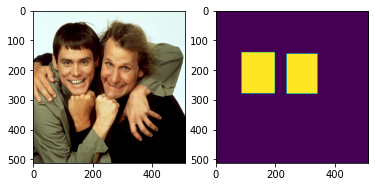

In [10]:
from random import randint

r=randint(1,img_set.shape[0])
print(r)
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img_set[r])
fig.add_subplot(1,2,2)
plt.imshow(mask[r])

In [11]:
#Split dataset into train,trst, valid
X_train,X_test,y_train,y_test=train_test_split(img_set,mask,test_size=0.1)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.1)
print(X_train.shape,X_test.shape,X_valid.shape)
print(y_train.shape,y_test.shape,y_valid.shape)


(331, 512, 512, 3) (41, 512, 512, 3) (37, 512, 512, 3)
(331, 512, 512) (41, 512, 512) (37, 512, 512)


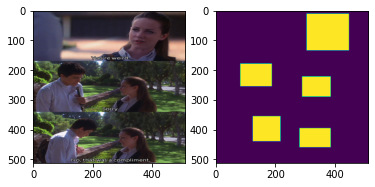

In [12]:
from random import randint

r=randint(1,X_train.shape[0])
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(X_train[r])
fig.add_subplot(1,2,2)
plt.imshow(y_train[r])

In [13]:
#Expanf y(label data) dimensions
y_train=np.expand_dims(y_train,3)
y_valid=np.expand_dims(y_valid,3)
y_test=np.expand_dims(y_test,3)
print(y_train.shape,y_valid.shape,y_test.shape)

(331, 512, 512, 1) (37, 512, 512, 1) (41, 512, 512, 1)


In [14]:
 #preprocess the X_train and X_valid to align with the encoder input
 X_train=preprocess_input(np.array(X_train,dtype=np.float32))
 X_valid=preprocess_input(np.array(X_valid,dtype=np.float32))
 X_test=preprocess_input(np.array(X_test,dtype=np.float32))
 print(X_train.shape,X_valid.shape,X_test.shape)



(331, 512, 512, 3) (37, 512, 512, 3) (41, 512, 512, 3)


In [35]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range = 40, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   brightness_range = (0.5, 1.5),
                                   fill_mode='nearest')



In [16]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape,BatchNormalization,Activation,Concatenate,UpSampling2D, Input

def create_model(IMAGE_SIZE):
  inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
  encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
  # Do not include classification (top) layer
  encoder.summary()
  # to freeze layers, except the new top layer, of course, which will be added below
  for layer in encoder.layers:
      layer.trainable = False
  
  f=[32,48,64,128,256]
  encod_output=encoder.get_layer("block_16_expand_relu").output
  skip_connections=['input_image','block_1_expand_relu','block_3_expand_relu','block_6_expand_relu','block_10_expand_relu']
  #model = Model(inputs=model.input, outputs=x)
  x=encod_output
  #print(encod_output)
  #encoder.summary()
  for i in range(1,len(skip_connections)+1):
    #print("Hi",i)
    x_encod=encoder.get_layer(skip_connections[-i]).output
    #print("Hi1",i)
    #print("shape is",x_encod.shape)
    x=UpSampling2D((2, 2))(x)
    #print("shape after upsampling ",x.shape)
    x=Concatenate()([x,x_encod])
    #print("shape after concat ",x.shape)

    x=Conv2D(f[-i],(3,3), padding="same")(x)
    #print("Conv1")
    x=Activation('relu')(x)

    x=Conv2D(f[-i],(3,3), padding="same")(x)
    #print("Conv2")
    x=Activation('relu')(x)
    print("Activation2")
  x = Conv2D(1, (1, 1), padding="same")(x)
  x = Activation("sigmoid")(x)
  print(x.shape)    
  model = Model(inputs, x)
  return model

In [18]:
model = create_model(IMAGE_SIZE)

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 513, 513, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 16) 64          Conv1[0][0]                      
_______________________________________________________________________________

In [19]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 513, 513, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 16) 64          Conv1[0][0]                      
_______________________________________________________________________________________

In [20]:
#Define loss functions
import tensorflow
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return tensorflow.keras.backend.binary_crossentropy(y_true, y_pred) - tensorflow.math.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [21]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.metrics import Recall, Precision

IMAGE_SIZE = 512
EPOCHS = 30
BATCH = 8
LR = 1e-4

PATH = "CVC-612/"
from keras.optimizers import Nadam
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

opt = Nadam(LR)
metrics = [dice_coefficient, Recall(), Precision()]
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)



In [ ]:
train_steps = len(X_train)//BATCH
valid_steps = len(X_valid)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_valid) % BATCH != 0:
    valid_steps += 1

model.fit(
    #x=aug.flow(
        X_train, y_train, batch_size=BATCH  
        #),
    ,validation_data=(X_valid,y_valid),
    epochs=30,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
42/42 [==============================] - 988s 24s/step - loss: 1.4786e-08 - dice_coefficient: 0.2057 - recall: 0.9999 - precision: 0.1243 - val_loss: 1.2872e-08 - val_dice_coefficient: 0.1834 - val_recall: 1.0000 - val_precision: 0.1082
Epoch 2/30
42/42 [==============================] - 991s 24s/step - loss: 1.4786e-08 - dice_coefficient: 0.2046 - recall: 0.9999 - precision: 0.1243 - val_loss: 1.2872e-08 - val_dice_coefficient: 0.1834 - val_recall: 1.0000 - val_precision: 0.1082
Epoch 3/30
42/42 [==============================] - 988s 24s/step - loss: 1.4786e-08 - dice_coefficient: 0.2054 - recall: 0.9999 - precision: 0.1243 - val_loss: 1.2872e-08 - val_dice_coefficient: 0.1834 - val_recall: 1.0000 - val_precision: 0.1082
Epoch 4/30
42/42 [==============================] - 988s 24s/step - loss: 1.4786e-08 - dice_coefficient: 0.2059 - recall: 0.9999 - precision: 0.1243 - val_loss: 1.2872e-08 - val_dice_coefficient: 0.1834 - val_recall: 1.0000 - val_precision: 0.1082
Epoch 5/

In [ ]:
import os
images=aug.flow(X_train,save_to_dir='augmented',save_format='png',save_prefix='aug',batch_sixe=1)
images=os.listir('augmented/')
for img in images:
  plt.imshow('augmented/'+img)

In [ ]:
model.evaluate(x=X_test,y=y_test)

2/2 [==============================] - 1s 506ms/step - loss: 1.9970e-08 - dice_coef: 0.2071 - recall_3: 0.0034 - precision_3: 0.0915


[1.9969709441625128e-08,
 0.20705558359622955,
 0.0033569049555808306,
 0.09149258583784103]

In [ ]:
predict_y=model.predict(X_test,verbose=1)
predict_y=(predict_y>0.5).astype(np.uint8)
i=randint(0,len(X_test))
fig,ax=plt.subplots(1,2,figsize(20,10))
ax[1].imshow(y_train[i])
ax[2].imshow(predict_y[i])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [ ]:
def create